# Plotting simulation data
All csv files generated by the R script are analyzed with the following code.

Some graphs required more advanced code, but the rationale behind is the same: saving to csv, loading data, clean and combine where needed, plot

## Import libraries

In [1]:
library(ggplot2)
library(tidyverse)
library(magrittr)
library(igraph)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.2.0     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
✔ purrr   1.0.1     

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The

## Load and combine data
The csv files to load depend on the network under analysis

In [2]:
# load the csv
df_sw <- read.csv("small//sm_1000n_10nei_nei2np_40means.csv")
df_sw_2 <- read.csv("small/sm_1000n_5nei_nei2np_40means.csv")

# add column to distinguish the datasets
df_sw["nei"] <- "5/n"
df_sw_2["nei"] <- "2/n"

# combine the datasets
df_sw_all <- rbind(df_sw, df_sw_2)

## The actual plotting

Warning message in geom_line(aes(col = type, shape = nei), linewidth = 0.7, linetype = 5):
“Ignoring unknown aesthetics: shape”
Warning message:
“Removed 33 rows containing missing values (`geom_segment()`).”


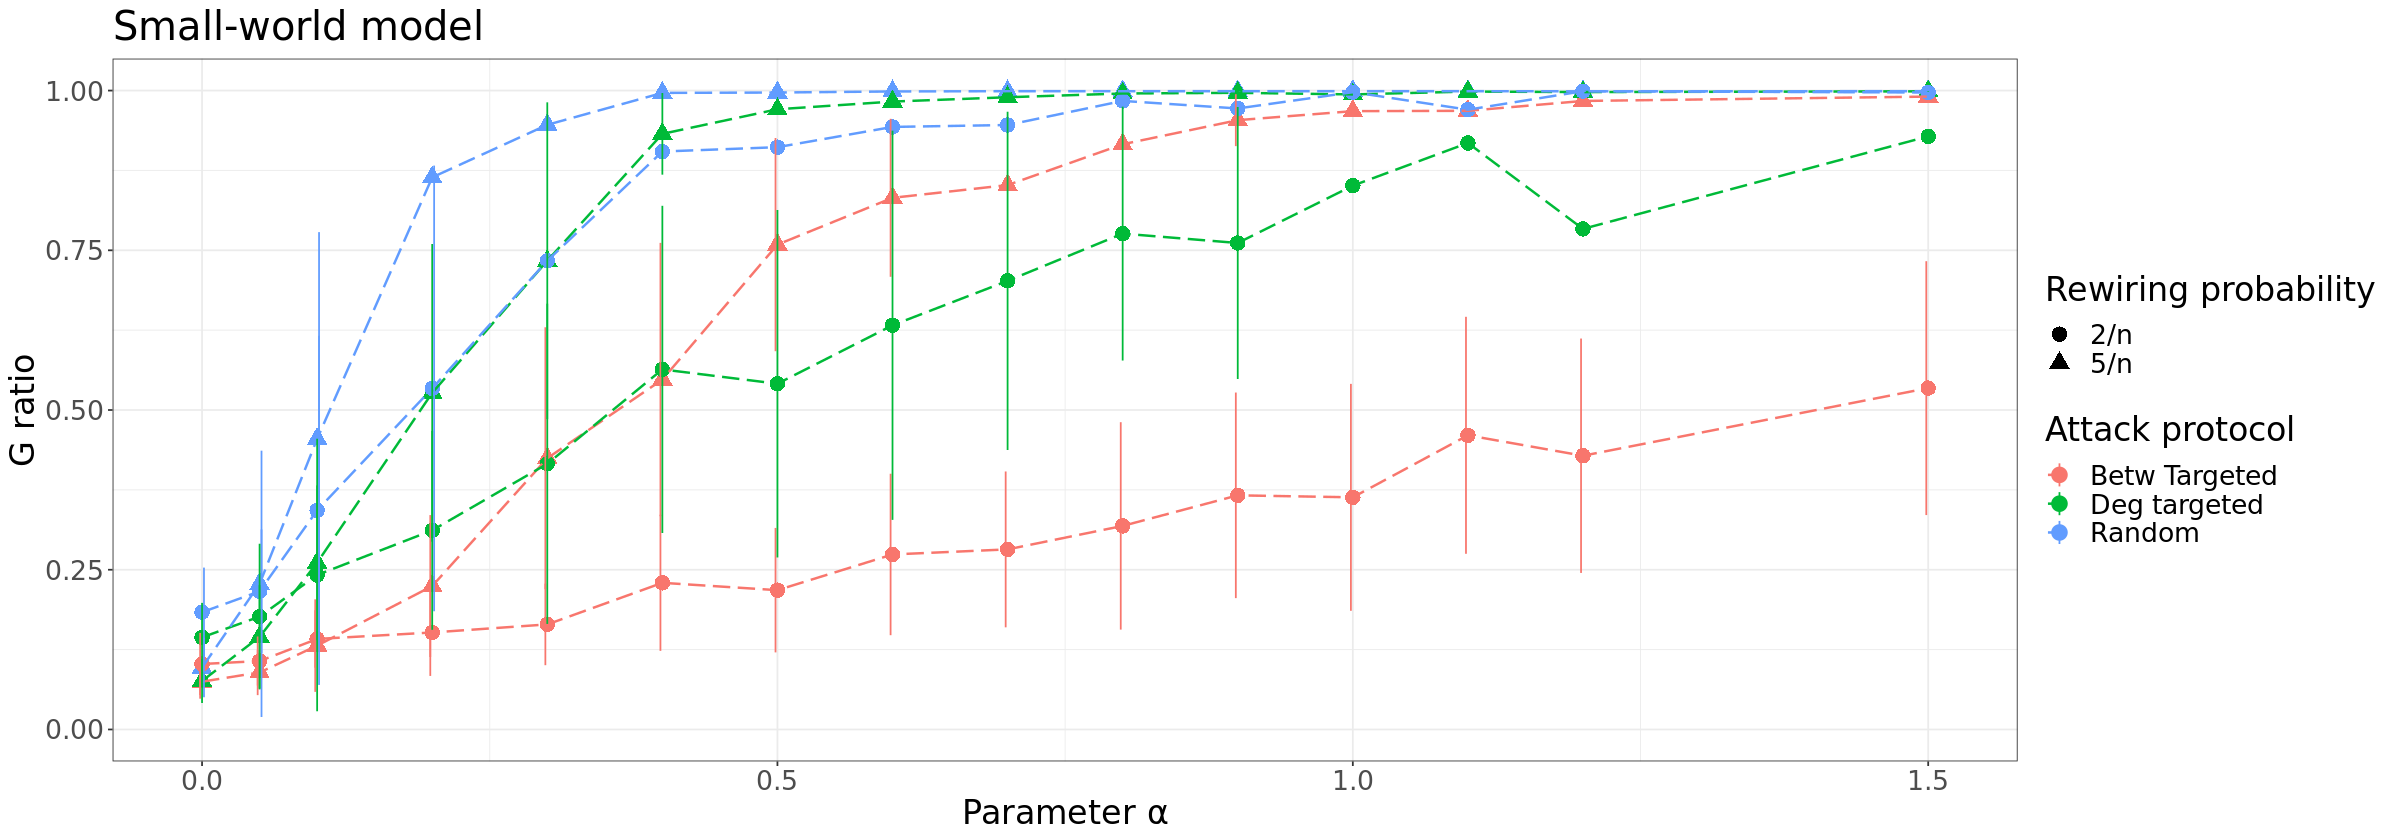

In [3]:
# plot nicely
options(repr.plot.width=20) # just to make it bigger on jupyter

plot_all<-ggplot(df_sw_all, aes(x = alpha,
                            y = g_ratio)) +
geom_point(aes(col = type, # add the points
               shape=nei), # distinguish by attack type and by the newly created column
           size = 4) +
geom_line(aes(col = type,
              shape=nei),
          linewidth = 0.7,
          linetype=5) +
geom_linerange(aes(x = alpha,   # add the error bars
                   ymin = g_ratio - g_ratio_sd,
                   ymax = g_ratio + g_ratio_sd,
                   col = type),
               position = position_dodge(0.005)) +
ylim(0, 1) + # for nicer plot and to give a comparable scale across different plots
# xlim(0, 0.2) + # give x axis limits in case they are needed
labs(x = expression(paste("Parameter ", alpha)), # set the labels according to the graph and network
     y = "G ratio",
     col = "Attack protocol",
     shape='Rewiring probability',
     title = expression(paste("Small-world model"))) +
theme_bw() +
theme(text = element_text(size = 20)) # bigger font size to increase readability on the final report

plot_all # check everything went fine

# uncomment belox to save to pdf
# ggsave(plot = plot_all, filename = "sw_1000n_40means.pdf", width = 10, height = 7, scale = 0.75)

# Special plots

## Average degree vs $\gamma$ in configuration model

In [4]:
# simulation parameters
n <- 100 # net size
n_indep<- 100 # independent attempts
k_min <- 2 # k min to sample
k_max <- n # k max to sample

# the sampling weights depending on the gamma exponent
weights_25 <- (k_min:k_max)^(-2.5)
weights_28 <- (k_min:k_max)^(-2.8)
weights_3 <- (k_min:k_max)^(-3)
weights_31 <- (k_min:k_max)^(-3.1)

In [5]:
# function to generate the graphs
# molloy reed configuration model with degree sequence 
# following a poer law distribution
degseq <- function(n, k_min, k_max, weights) {
    degs <- sample(c(k_min:k_max), size = n, replace = TRUE, prob = weights)
    if (sum(degs) %% 2 == 1) {
        degs[1] <- degs[1] + 1
    }
    g <- igraph::sample_degseq(out.deg = degs, method = "vl")
    return(g)
}

In [6]:
# sample the graphs and store the results
dd_25 <- vector()
dd_28 <- vector()
dd_3 <- vector()
dd_31 <- vector()

for (i in 1:n_indep) {
    g <- degseq(n, k_min, k_max, weights_25)
    dd_25[i] <- mean(degree(g))
}
for (i in 1:n_indep) {
    g <- degseq(n, k_min, k_max, weights_28)
    dd_28[i] <- mean(degree(g))
}
for (i in 1:n_indep) {
    g <- degseq(n, k_min, k_max, weights_3)
    dd_3[i] <- mean(degree(g))
}
for (i in 1:n_indep) {
    g <- degseq(n, k_min, k_max, weights_31)
    dd_31[i] <- mean(degree(g))
}

In [7]:
# clean and combine the data
d_25<-as.data.frame(dd_25)
d_25['gamma']<-'2.5'
d_28<-as.data.frame(dd_28)
d_28['gamma']<-'2.8'
d_3<-as.data.frame(dd_3)
d_3['gamma']<-'3'
d_31<-as.data.frame(dd_31)
d_31['gamma']<-'3.1'
colnames(d_31)<-c('deg', 'gamma')
colnames(d_3)<-c('deg', 'gamma')
colnames(d_25)<-c('deg', 'gamma')
colnames(d_28)<-c('deg', 'gamma')

dd<-rbind(d_25, d_28, d_3, d_31)

Warning message in geom_density(data = dd, alpha = 0.6, aes(x = deg, fill = gamma, :
“Ignoring unknown parameters: `binwidth`”
Warning message:
“`stat(density)` was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


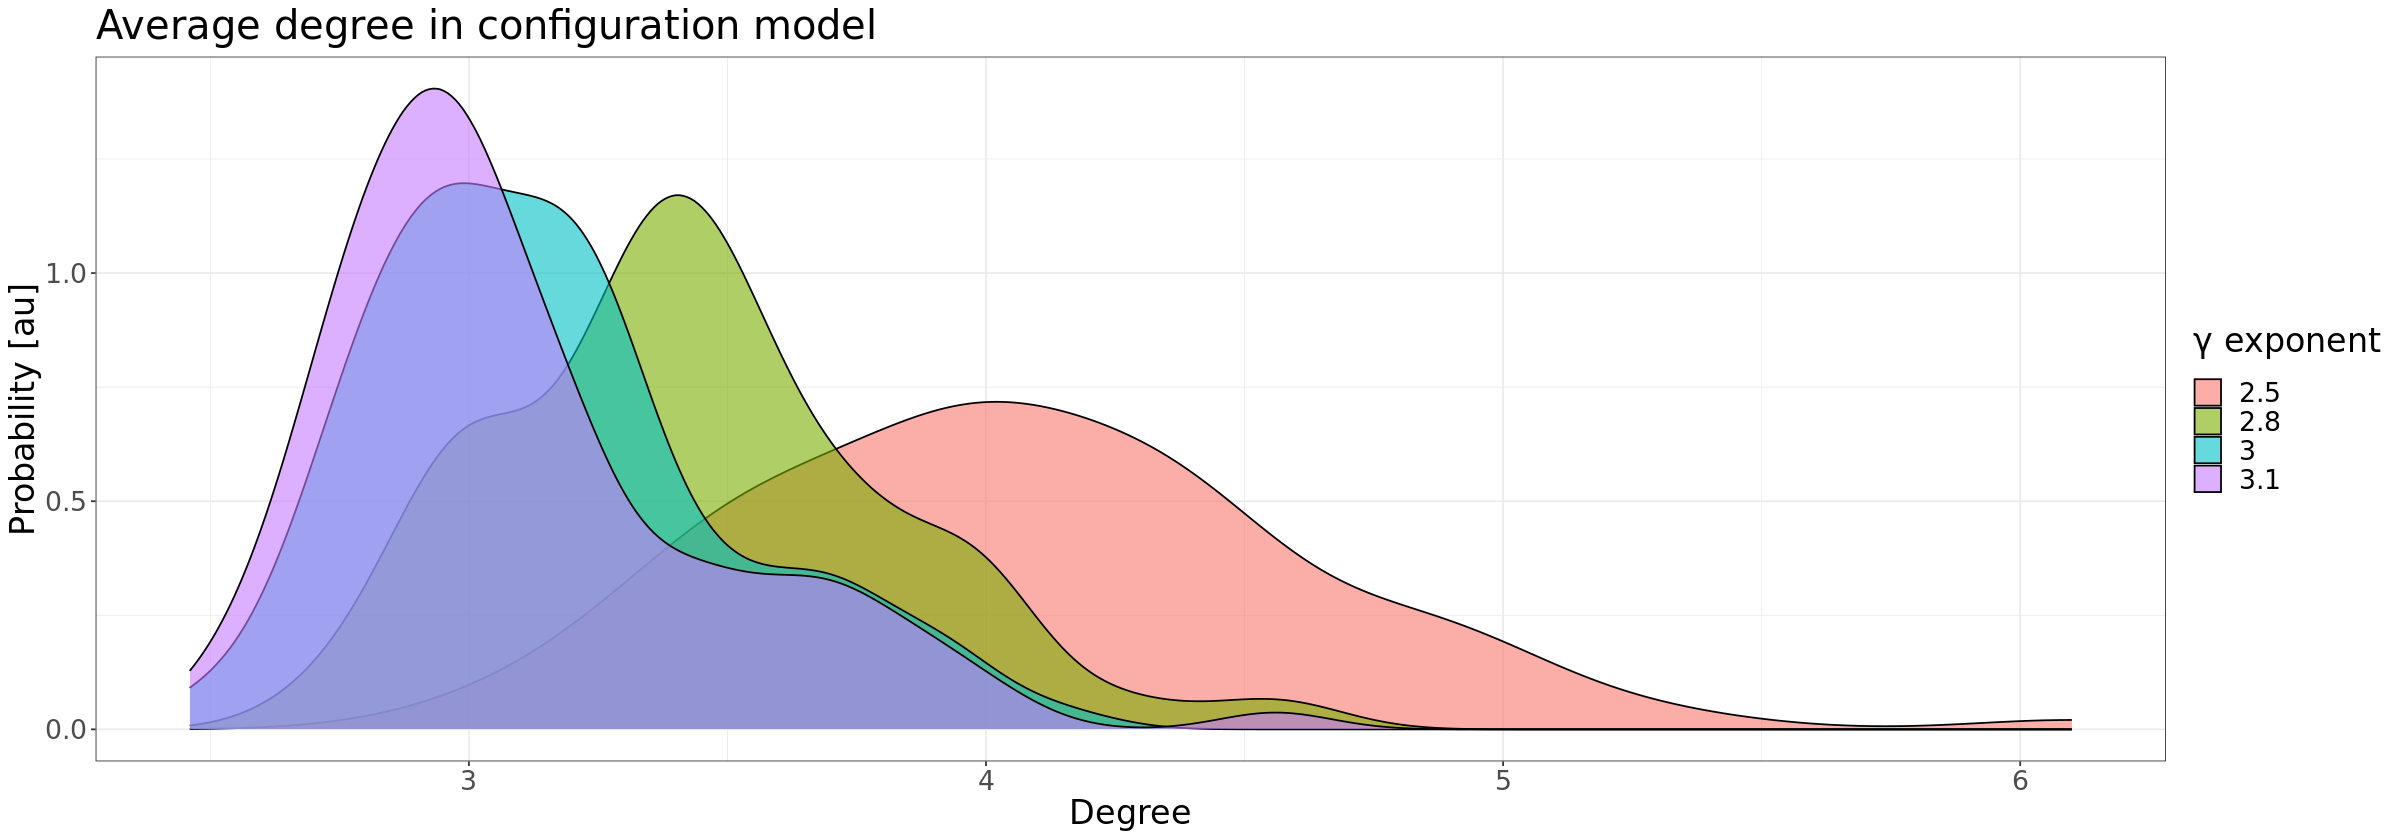

In [8]:
# plot the results and save them
deg_distrib <- ggplot(dd) +
geom_density(data = dd,
             alpha = 0.6,
             aes(x = deg,
                 fill = gamma,
                 y = stat(density)), 
             binwidth = 0.06) +
theme_bw() +
labs(x = "Degree",
     y = "Probability [au]",
     fill = expression(paste(gamma, " exponent")), 
     title = "Average degree in configuration model") +
theme(text = element_text(size = 20))

deg_distrib

# uncomment belox to save to pdf
# ggsave(plot = deg_distrib, filename = "degree_distrib_conf.pdf", width = 10, height = 7, scale = 0.75)

## G ratio distribution depending on $\alpha$ on Barabasi-Albert networks

In [9]:
# load clean and combine the simulation data
# they are the G ratios for many independent realization of the BA model
# after cascades are triggered at different values of alpha 

df_hist<-read.csv('pa/pa_hist_2_5_1_1000n_4m_2000means.csv')

# just separate in a dataframe adding info on the alpha used
d02<-as.data.frame(df_hist[,2])
d02['alpha']<-'0.1'
d05<-as.data.frame(df_hist[,3])
d05['alpha']<-'0.5'
d1<-as.data.frame(df_hist[,4])
d1['alpha']<-'1'

# normalize the dataframes
colnames(d1)<-c('v','alpha')
colnames(d02)<-c('v','alpha')
colnames(d05)<-c('v','alpha')

# combine for easier plotting
df_hist_comb<-rbind(d02,d05,d1)

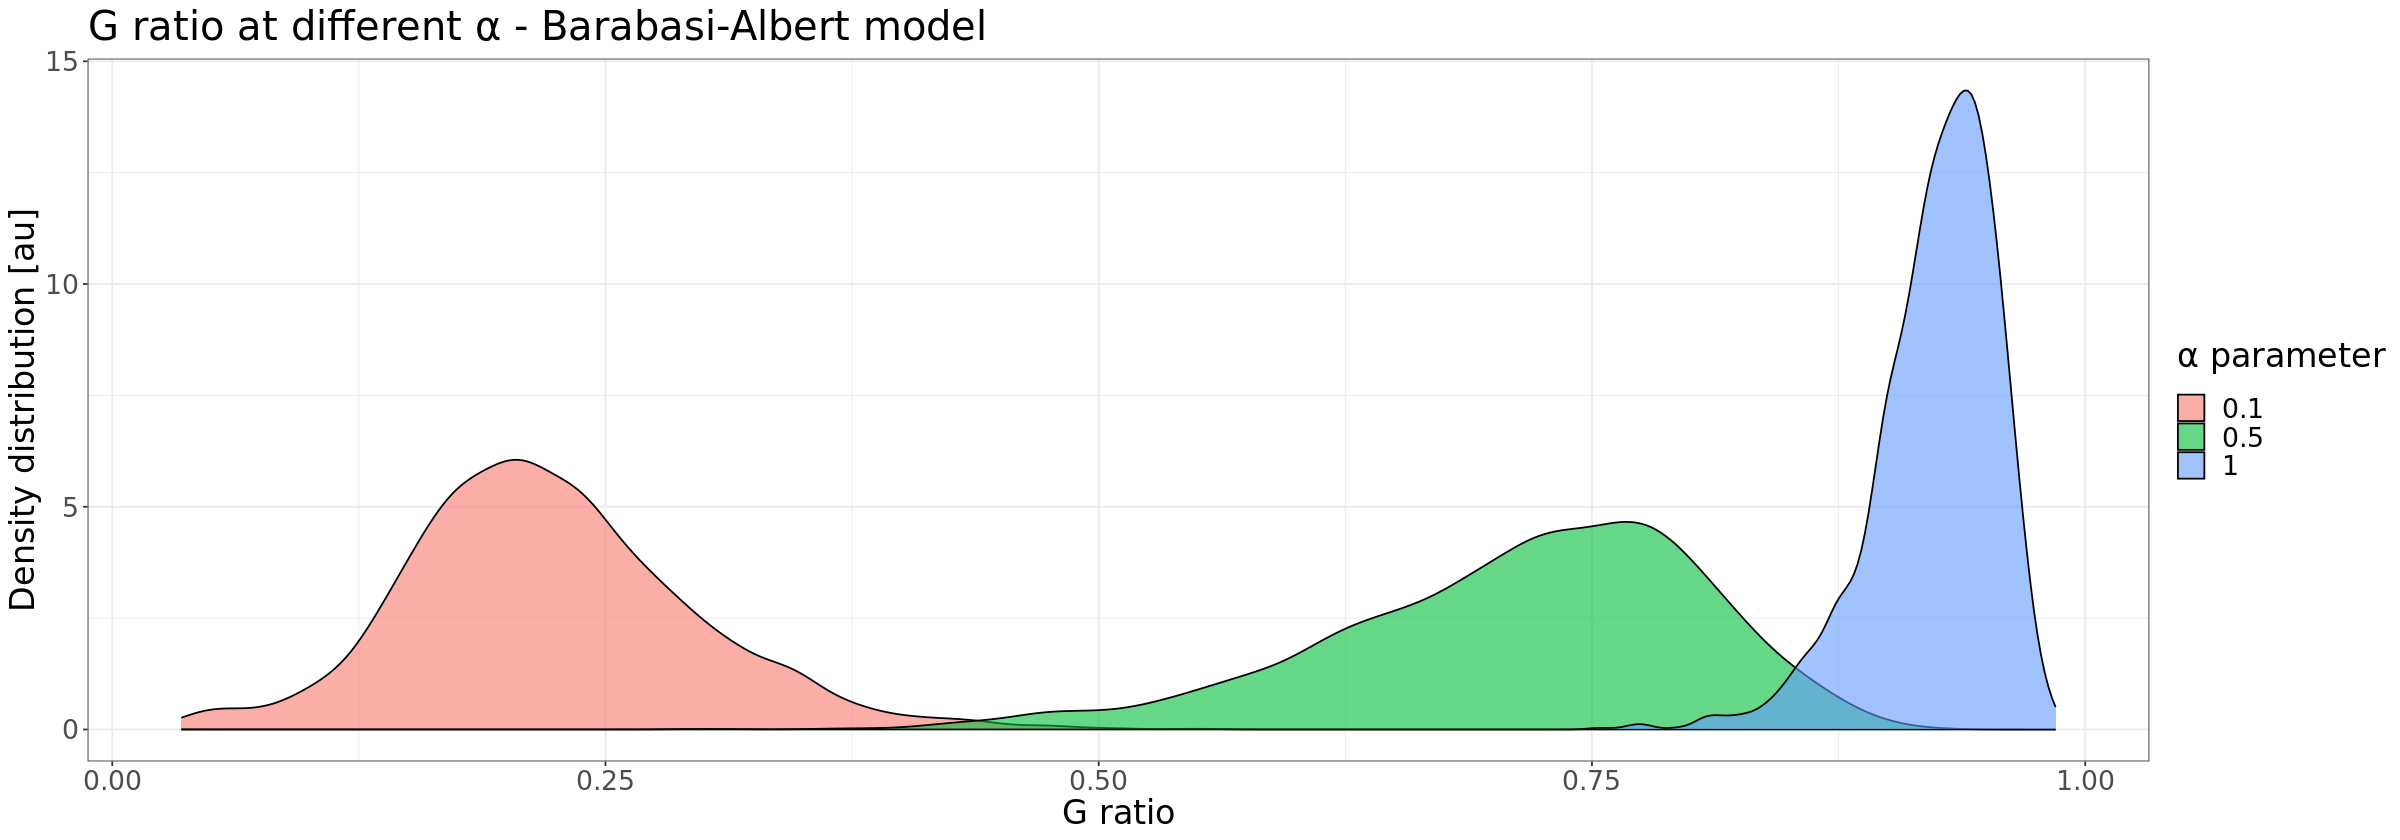

In [10]:
density_distrib <- ggplot(df_hist_comb) +
labs(x = "G ratio",
     y = "Density distribution [au]",
     title=expression(paste('G ratio at different ',alpha, ' - Barabasi-Albert model')),
     fill = expression(paste(alpha, " parameter"))) +
theme_bw() +
geom_density(aes(x = v,
                 y = stat(density),
                 fill = alpha),
             alpha = 0.6,
             linetype = 1, )+
theme(text = element_text(size = 20))

density_distrib

# uncomment belox to save to pdf
# ggsave(filename = 'pa_g_different_alpha.pdf', plot = density_distrib, width=10, height = 7, scale = 0.75)